# Importing Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from xgboost import XGBRegressor
import xgboost as xgb

# Reading The Train CSV Files

In [2]:
HDBee = pd.read_csv('Data_Sprint_data/train.csv')

/var/folders/2r/mv3psfc9023ck75szgbr9gxr0000gn/T/ipykernel_42939/1352755436.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  HDBee = pd.read_csv('Data_Sprint_data/train.csv')


# Data Structure: Rows/ Columns

In [3]:
print(f"Dataset shape: {HDBee.shape[0]} rows × {HDBee.shape[1]} columns")

Dataset shape: 150634 rows × 78 columns


# Checking for Duplication

In [4]:
# There are no duplicated rows in the dataset
HDBee.duplicated().sum()

np.int64(0)

# Checking for Nulls

In [5]:
# Checking for Nulls
missing_values = HDBee.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Mall_Nearest_Distance      829
Mall_Within_500m         92789
Mall_Within_1km          25426
Mall_Within_2km           1940
Hawker_Within_500m       97390
Hawker_Within_1km        60868
Hawker_Within_2km        29202
dtype: int64


## Verifying Nulls For Mall



In [6]:
# There are no nulls values for Mall_Within_500m if the Mall Distance is less than 500m
temp_holder = HDBee[HDBee['Mall_Nearest_Distance'] <= 500]
temp_holder['Mall_Within_500m'].isnull().sum()

np.int64(0)

In [7]:
# There are no nulls values for Mall_Within_1km if the Mall Distance is less than 1km
temp_holder = HDBee[HDBee['Mall_Nearest_Distance'] <= 1000]
temp_holder['Mall_Within_1km'].isnull().sum()

np.int64(0)

In [8]:
# There are no nulls values for Mall_Within_2km if the Mall Distance is less than 2km
temp_holder = HDBee[HDBee['Mall_Nearest_Distance'] <= 2000]
temp_holder['Mall_Within_2km'].isnull().sum()

np.int64(0)

## Verifying Nulls For Hawker



In [9]:
# There are no nulls values for Hawker_Within_500m if the Hawker Distance is less than 500m
temp_holder = HDBee[HDBee['Hawker_Nearest_Distance'] <= 500]
temp_holder['Hawker_Within_500m'].isnull().sum()

np.int64(0)

In [10]:
# There are no nulls values for Hawker_Within_1km if the Hawker Distance is less than 1km
temp_holder = HDBee[HDBee['Hawker_Nearest_Distance'] <= 1000]
temp_holder['Hawker_Within_1km'].isnull().sum()

np.int64(0)

In [11]:
# There are no nulls values for Hawker_Within_2km if the Hawker Distance is less than 2km
temp_holder = HDBee[HDBee['Hawker_Nearest_Distance'] <= 2000]
temp_holder['Hawker_Within_2km'].isnull().sum()

np.int64(0)

#### It is safe to say that all the null values in the data set for the distance are = 0
##### Therefore, I will replace the nulls with 0

# Verifying Nulls for Mall_Nearest_Distance

In [12]:
# Checking total number of nulls for Mall Nearest DIstance
HDBee['Mall_Nearest_Distance'].isnull().sum()

np.int64(829)

In [13]:
# Checking if the nulls in 'Mall Nearest Distance' is unique in the columns [when comparing with postal code]
# Meaning to say I cannot copy the Mall Neareset Distance based on the same postal code
HDBee['is_null'] = HDBee['Mall_Nearest_Distance'].isnull()
HDBee['is_not_null'] = HDBee['Mall_Nearest_Distance'].notnull()

temp_holder = (
    HDBee.groupby('postal')[['is_null', 'is_not_null']]
    .sum()
    .query('is_null > 0')
    .sort_values(by='is_null', ascending=False)
)
temp_holder.head(10)

,is_null,is_not_null
postal,,
141087,38,0
600057,21,0
142088,19,0
821678,15,0
463808,13,0
372018,13,0
522871,13,0
681815,13,0
681803,12,0


In [14]:
# Verify again that no nulls in postalcode, if there is any in nulls
temp_holder[temp_holder['is_not_null'] > 0]

,is_null,is_not_null
postal,,


In [16]:
# Drop columns that i created for verification
HDBee = HDBee.drop(['is_null', 'is_not_null'], axis= 1)

#### As there are 829 columns with null, filtering the table for is_not_null to have values and ensuring that is_null have no values
#### Since this is 829 columns, less than 1% of the data, we will drop the rows with nulls

# Handling Nulls

In [ ]:
# Mention above, dropping the row with 'Mall nearest distance' = null 
# And replacing all nulls with 0 (For hawker and mall)

HDBee = HDBee[~HDBee['Mall_Nearest_Distance'].isnull()]
HDBee.fillna(0, inplace= True)

In [ ]:
# Verify that there is no more nulls
missing_values = HDBee.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


# Checking Data Types

In [19]:
# Data types
print("Data types:")
print(HDBee.dtypes)

Data types:
id                     int64
Tranc_YearMonth       object
town                  object
flat_type             object
block                 object
                      ...   
sec_sch_name          object
cutoff_point           int64
affiliation            int64
sec_sch_latitude     float64
sec_sch_longitude    float64
Length: 78, dtype: object


# Changing Date to Date Type

In [ ]:
# CHaning to date time
HDBee['Tranc_YearMonth'] = pd.to_datetime(HDBee['Tranc_YearMonth'])

In [21]:
HDBee.dtypes

id                            int64
Tranc_YearMonth      datetime64[ns]
town                         object
flat_type                    object
block                        object
                          ...      
sec_sch_name                 object
cutoff_point                  int64
affiliation                   int64
sec_sch_latitude            float64
sec_sch_longitude           float64
Length: 78, dtype: object

# Chaning Boolean Features to Boolean Type

In [ ]:
# Replacing  bool col with Y and N to binary
bool_column = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
HDBee[bool_column] = HDBee[bool_column].replace({'Y': 1, 'N': 0})

/var/folders/2r/mv3psfc9023ck75szgbr9gxr0000gn/T/ipykernel_42939/3718239028.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  HDBee[bool_column] = HDBee[bool_column].replace({'Y': 1, 'N': 0})


In [ ]:
# Chaning all 1 and 0 boonlean column to boolean type
bool_column = ['bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
HDBee[bool_column] = HDBee[bool_column].astype(bool)

# Filtering Unncessary Features

In [ ]:
# Taking all all the not so important features discussed with the team
not_important_feature = ['id', 'Tranc_Year', 'Tranc_Month',
                         'block', 'street_name', 'address', 'postal', 'town',
                         'storey_range', 'lower', 'mid', 'upper', 
                         'full_flat_type',
                         'floor_area_sqm', 'price_per_sqft',
                         'year_completed',
                         'residential',
                         'total_dwelling_units',
                         '1room_rental', '2room_rental', '3room_rental', 'other_room_rental',
                         'planning_area', 
                         'bus_stop_name',
                         '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold',
                         'bus_stop_latitude', 'bus_stop_longitude',
                         'Latitude', 'Longitude',
                         'mrt_latitude', 'mrt_longitude',
                         'pri_sch_latitude', 'pri_sch_longitude',
                         'sec_sch_latitude', 'sec_sch_longitude',
                         'pri_sch_name', 'pri_sch_affiliation',
                         'sec_sch_name', 'affiliation']

In [ ]:
# Dropping the no so important columns from df
HDBee_df = HDBee.drop(not_important_feature, axis= 1)

# Creating New Features

In [ ]:
# Creating functions to create the floor level (splitting them into 4 groups)
def floor_level (row):
    mid = row['mid_storey']
    max = row['max_floor_lvl']

    percent = (mid/ max) * 100.0

    if percent < 25:
        level = 'Lower Level'
    elif percent < 50:
        level = 'Mid Lower Level'
    elif percent < 75:
        level = 'Mid Upper Level'
    else:
        level = 'Upper Level'
    return level

In [ ]:
# Creating new column for the level range
HDBee_df['floor_level_range'] = HDBee_df.apply(floor_level, axis=1)

In [32]:
#C Check if the floor_level_range is accurate
HDBee_df[['mid_storey', 'max_floor_lvl', 'floor_level_range']]

,mid_storey,max_floor_lvl,floor_level_range
0,14,16,Upper Level
1,14,16,Upper Level
2,8,16,Mid Upper Level
3,2,4,Mid Upper Level
4,5,4,Upper Level
...,...,...,...
150629,8,12,Mid Upper Level
150630,2,12,Lower Level
150631,11,12,Upper Level
150632,2,12,Lower Level


In [33]:
# Remove the features used to calculate
HDBee_df = HDBee_df.drop(['mid_storey', 'max_floor_lvl'], axis= 1)

##### New Features for Years of Lease Left

In [ ]:
# Creating new column for years of lease left
HDBee_df['years_of_lease_left'] = 99 - HDBee_df['hdb_age']

In [ ]:
# Dropping hdb age column
HDBee_df = HDBee_df.drop(['hdb_age'], axis= 1)

In [36]:
HDBee_df.mrt_name.unique()

array(['Mattar', 'Ubi', 'Jurong East', 'Bukit Gombak', 'Tanah Merah',
       'Bedok Reservoir', 'Tampines East', 'Chinese Garden',
       'Yio Chu Kang', 'Boon Keng', 'Toa Payoh', 'Khatib', 'Queenstown',
       'Bedok', 'Bukit Batok', 'Yishun', 'Kovan', 'Ang Mo Kio',
       'Tampines West', 'Canberra', 'Eunos', 'Bishan', 'Bedok North',
       'Simei', 'Buangkok', 'Woodlands', 'Kaki Bukit', 'Hougang',
       'Serangoon', 'Bukit Panjang', 'Clementi', 'Tampines', 'Marsiling',
       'Tanjong Pagar', 'Outram Park', 'Farrer Park', 'Potong Pasir',
       'Lakeside', 'Woodlands North', 'Braddell', 'Woodleigh',
       'HarbourFront', 'Geylang Bahru', 'Tiong Bahru', 'Kembangan',
       'Telok Blangah', 'Mountbatten', 'Lorong Chuan', 'Aljunied',
       'one-north', 'Buona Vista', 'Lavender', 'Bencoolen', 'Bras Basah',
       'Chinatown', 'Little India', 'Redhill', 'Jalan Besar',
       'Paya Lebar', 'Farrer Road', 'Pioneer', 'Cashew', 'Dover',
       'Punggol', 'Holland Village', 'Choa Chu Kang'

#### Creating MRT category

In [ ]:
# groupping the mrt station into regions
west_mrt = ['Jurong East', 'Chinese Garden', 'Lakeside', 'Boon Lay', 'Pioneer','Bukit Batok',
            'Bukit Gombak','Bukit Panjang','Choa Chu Kang','Yew Tee','Hillview','Cashew','Clementi',
            'Beauty World', 'Bukit Timah']

east_mrt = ['Tanah Merah','Bedok','Bedok North','Bedok Reservoir','Kaki Bukit', 'Kembangan','Eunos',
            'Ubi','MacPherson','Paya Lebar','Tai Seng','Mattar','Simei','Tampines','Tampines East',
            'Tampines West','Pasir Ris','Upper Changi','Changi Airport']

north_mrt = ['Yishun','Khatib','Canberra','Sembawang','Woodlands','Woodlands North','Woodlands South',
             'Marsiling','Admiralty']

north_east_mrt = ['Yio Chu Kang', 'Ang Mo Kio','Serangoon','Kovan','Hougang','Buangkok','Sengkang',
                  'Punggol','Bartley']

central_mrt = ['Toa Payoh','Braddell','Bishan','Marymount','Caldecott','Lorong Chuan','Queenstown',
               'Redhill','Commonwealth','Buona Vista','one-north','Dover','Holland Village',
               'Botanic Gardens','Tan Kah Kee','Farrer Road','Novena','Little India','Rochor','Bugis',
               'Bencoolen','Clarke Quay','Chinatown','Outram Park','Telok Blangah','Labrador Park',
               'HarbourFront','Mountbatten','Dakota','Aljunied','Lavender','Kallang','Geylang Bahru',
               'Jalan Besar','Potong Pasir','Bendemeer','Farrer Park','Nicoll Highway','Tanjong Pagar']


In [ ]:
# Creating functions for the mrt region
def mrt_location (row):
    if row['mrt_name'] in west_mrt:
        mrt_region = 'west'
    elif row['mrt_name'] in east_mrt:
        mrt_region = 'east'
    elif row['mrt_name'] in north_mrt:
        mrt_region = 'north'
    elif row['mrt_name'] in north_east_mrt:
        mrt_region = 'north_east'
    else:
        mrt_region = 'central'
    return mrt_region

In [ ]:
# Create a new column for the region applying the functions
HDBee_df['mrt_region'] = HDBee_df.apply(mrt_location, axis=1)

In [ ]:
# Checking if the column/ function is working
HDBee_df.mrt_region.value_counts()

mrt_region
west          36164
north_east    36014
east          28221
north         25059
central       24347
Name: count, dtype: int64

In [ ]:
# drop the mrt name column
HDBee_df = HDBee_df.drop(['mrt_name'], axis=1)

# To find outliers

In [ ]:
# Filtering to only get features that are numberical (not including Boolean)
HDBee_df_numer = HDBee_df.select_dtypes(include= ['number'])

In [ ]:
# create a function to find the outliers
def iqr_outliers(outliers):
    q1 = outliers.quantile(0.25)
    q3 = outliers.quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5*iqr
    upper_whisker = q3 + 1.5*iqr
    return lower_whisker, upper_whisker

In [ ]:
# put the outliers into the outliers_col list
outliers_col = []
for col in HDBee_df_numer.columns:
    lower, upper = iqr_outliers(HDBee_df_numer[col])
    if ((HDBee_df_numer[col].min()) < lower) | ((HDBee_df_numer[col].max()) > upper):
        outliers_col.append(col)
outliers_col

['resale_price',
 'floor_area_sqft',
 'Mall_Nearest_Distance',
 'Mall_Within_500m',
 'Mall_Within_1km',
 'Mall_Within_2km',
 'Hawker_Nearest_Distance',
 'Hawker_Within_500m',
 'Hawker_Within_1km',
 'Hawker_Within_2km',
 'hawker_food_stalls',
 'hawker_market_stalls',
 'mrt_nearest_distance',
 'bus_stop_nearest_distance',
 'pri_sch_nearest_distance',
 'vacancy',
 'sec_sch_nearest_dist']

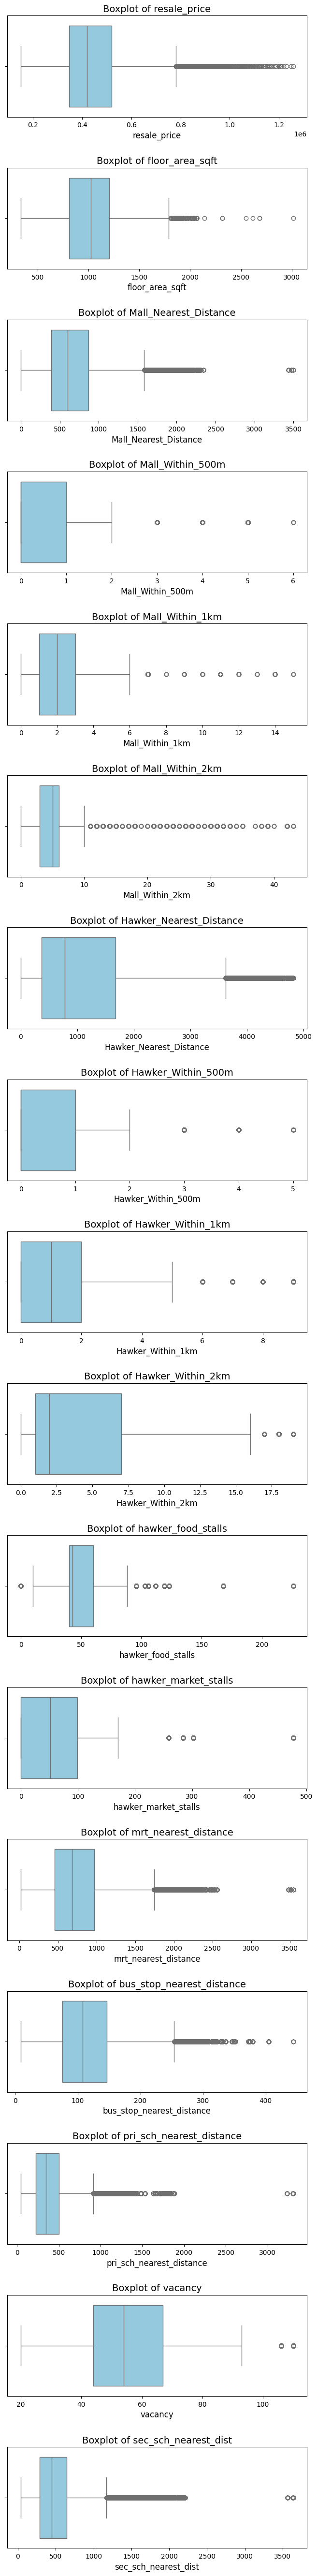

In [ ]:
# for items that was identify as outliers, create a box plot
num_outlier_cols = len(outliers_col)
fig, axes = plt.subplots(nrows=num_outlier_cols, ncols=1, figsize=(8, num_outlier_cols * 4))
for i, col in enumerate(outliers_col):
    sns.boxplot(x=HDBee_df_numer[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    plt.subplots_adjust(hspace=0.5)

# Handling Outliers

In [ ]:
# Drawing a threshold to elimiate the outliers of outliers that may skewed th data
HDBee_df = HDBee_df[
    (HDBee_df['Mall_Nearest_Distance'] < 3000) &
    (HDBee_df['hawker_food_stalls'] < 150) &
    (HDBee_df['hawker_market_stalls'] < 400) &
    (HDBee_df['mrt_nearest_distance'] < 3000) &
    (HDBee_df['bus_stop_nearest_distance'] < 400) &
    (HDBee_df['pri_sch_nearest_distance'] < 3000) &
    (HDBee_df['vacancy'] < 100) &
    (HDBee_df['sec_sch_nearest_dist'] < 3000)
]

# After Dashboard [ Refer to Tableau]

# Remove features after Dashboard

In [ ]:
# After dashboard from Tableau, the team identify more columns that might not have any correlation with the retail price
col_to_drop_after_dashboard = ['precinct_pavilion',
                               'Mall_Nearest_Distance', 
                               'Hawker_Nearest_Distance', 
                               'hawker_food_stalls', 'hawker_market_stalls',
                               'bus_interchange',
                               'bus_stop_nearest_distance', 
                               'sec_sch_nearest_dist', 'cutoff_point',
                               'flat_model',
                               'lease_commence_date',
                               'flat_model']

In [ ]:
# Dropping the columns
HDBee_fm = HDBee_df.drop(col_to_drop_after_dashboard, axis=1)

# One Hot Encoding

In [ ]:
# Filtering to only get features that are cateogirical 
cat_col = HDBee_fm.select_dtypes(include= ['object'])

In [ ]:
# Displaying all the items in the cateogirical group
for col in cat_col.columns:
    print(f"\nColumn: {col}")
    print(cat_col[col].value_counts())


Column: flat_type
flat_type
4 ROOM              59876
3 ROOM              38652
5 ROOM              35466
EXECUTIVE           11957
2 ROOM               1887
1 ROOM                 82
MULTI-GENERATION       56
Name: count, dtype: int64

Column: floor_level_range
floor_level_range
Mid Upper Level    44066
Upper Level        41192
Mid Lower Level    35211
Lower Level        27507
Name: count, dtype: int64

Column: mrt_region
mrt_region
west          36164
north_east    34586
east          28149
north         25059
central       24018
Name: count, dtype: int64


In [ ]:
# Decided to drop multi generation because the data point was very small and might not be enough to train the model
HDBee_fm = HDBee_fm[HDBee_fm['flat_type'] != 'MULTI-GENERATION']

In [ ]:
# Checking the items again
cat_col = HDBee_fm.select_dtypes(include= ['object'])

In [ ]:
# Confirm that multi generation was dropped)
for col in cat_col.columns:
    print(f"\nColumn: {col}")
    print(cat_col[col].value_counts())


Column: flat_type
flat_type
4 ROOM       59876
3 ROOM       38652
5 ROOM       35466
EXECUTIVE    11957
2 ROOM        1887
1 ROOM          82
Name: count, dtype: int64

Column: floor_level_range
floor_level_range
Mid Upper Level    44048
Upper Level        41180
Mid Lower Level    35194
Lower Level        27498
Name: count, dtype: int64

Column: mrt_region
mrt_region
west          36164
north_east    34586
east          28135
north         25024
central       24011
Name: count, dtype: int64


In [ ]:
 # One hot encode the categiry column and drop the columns with the lowest values as well as the original column
for col in cat_col.columns:
    dummies = pd.get_dummies(HDBee_fm[col], drop_first= True)
    HDBee_fm = pd.concat([HDBee_fm, dummies], axis=1)

HDBee_fm.drop(columns=cat_col.columns, inplace=True)


# Correlation

In [ ]:
# pushing the resales price to the last column for better reference for correlation
HDBee_fm = HDBee_fm[[col for col in HDBee_fm.columns if col != 'resale_price'] + ['resale_price']]

In [64]:
corr_mat = HDBee_fm.corr()

In [65]:
corr_mat.to_csv('corr.csv')

In [66]:
#Features to remove after checking corr 
# Include Tranc_YearMonth because if we are using to predict present housing price, then it doesnt matter because no data to train on
features_to_remove = ['market_hawker', 'multistorey_carpark', 'pri_sch_nearest_distance',
                      'Hawker_Within_500m', 'Hawker_Within_1km', 'Mall_Within_500m', 'Mall_Within_1km', 'Tranc_YearMonth']

In [ ]:
# dropping more features after the correlation
HDBee_fm = HDBee_fm.drop(features_to_remove, axis= 1)

# Model

In [ ]:
# Finalise the features to use for the model
feature_col = ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km',
               'mrt_nearest_distance', 'mrt_interchange', 'years_of_lease_left', '1 ROOM', '2 ROOM',
               '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Lower Level', 'Mid Lower Level', 'Mid Upper Level', 
               'Upper Level', 'east', 'north', 'north_east', 'west', 'central']

In [70]:
X = HDBee_fm[feature_col]
y = HDBee_fm['resale_price']

In [ ]:
# Create function for liner regression
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.resale_price

    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=123)

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_pred = linreg.predict(X_test)
    rmse = metrics.root_mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return rmse, r2

In [ ]:
# trying different set of features for the model
feature_sets = {
    'Base': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE'],
    'Add MRT': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'mrt_nearest_distance', 'mrt_interchange'],
    'Add Amenities': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mall_Within_2km', 'Hawker_Within_2km'],
    'Add Region': ['floor_area_sqft', 'years_of_lease_left', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE','east', 'north', 'north_east', 'west'],
    'All except MRT distance/ interchange': ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km', 'years_of_lease_left','2 ROOM','3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mid Lower Level', 'Mid Upper Level', 'Upper Level', 'east', 'north', 'north_east', 'west'],
    'Add Everything' : ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km','mrt_nearest_distance', 'mrt_interchange', 'years_of_lease_left','2 ROOM','3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Mid Lower Level', 'Mid Upper Level', 'Upper Level', 'east', 'north', 'north_east', 'west', 'vacancy']
}

In [ ]:
# Capturing the ressults for liner regression after going throught the pre-define features groups
results = {}
for name, cols in feature_sets.items():
    rmse, r2 = train_test_rmse(HDBee_fm, cols)
    results[name] = {'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T.sort_values('RMSE')
print(results_df)


                                               RMSE        R2
Add Everything                         70990.961121  0.752894
All except MRT distance/ interchange   72806.620092  0.740092
Add Amenities                          78418.347541  0.698482
Add Region                             80309.711914  0.683762
Add MRT                               100385.373674  0.505896
Base                                  103908.835856  0.470602


# XGBoost

In [74]:
X = HDBee_fm[feature_col] 
y = HDBee_fm['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)


In [ ]:
# Define function for XGBoost
def train_test_rmse_xgb(df, feature_cols):
    X = df[feature_cols]
    y = df['resale_price']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=123
    )

    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=123,
        n_jobs=-1
    )

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


# Compare the same groups of features with XGBoost
results = {}
for name, cols in feature_sets.items():
    rmse, r2 = train_test_rmse_xgb(HDBee_fm, cols)
    results[name] = {'RMSE': rmse, 'R2': r2}

# Display sorted results
results_df = pd.DataFrame(results).T.sort_values('RMSE')
print(results_df)


                                              RMSE        R2
Add Everything                        38748.440142  0.926382
All except MRT distance/ interchange  45598.995741  0.898050
Add Amenities                         52223.104610  0.866278
Add Region                            56714.167464  0.842290
Add MRT                               67190.496925  0.778643
Base                                  82696.885823  0.664683


# Test.CSV

In [ ]:
# Read test data
test_data = pd.read_csv('Data_Sprint_data/test.csv')

/var/folders/2r/mv3psfc9023ck75szgbr9gxr0000gn/T/ipykernel_42939/2837025088.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('Data_Sprint_data/test.csv')


In [ ]:
# combine all functions/ cleaning anf processing EDA into this cell
bool_column = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
test_data[bool_column] = test_data[bool_column].replace({'Y': 1, 'N': 0})
bool_column = ['bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
test_data[bool_column] = test_data[bool_column].astype(bool)
test_data['floor_level_range'] = test_data.apply(floor_level, axis=1)
test_data['years_of_lease_left'] = 99 - test_data['hdb_age']
test_data['mrt_region'] = test_data.apply(mrt_location, axis=1)
test_data = test_data[
    (test_data['Mall_Nearest_Distance'] < 3000) &
    (test_data['hawker_food_stalls'] < 150) &
    (test_data['hawker_market_stalls'] < 400) &
    (test_data['mrt_nearest_distance'] < 3000) &
    (test_data['bus_stop_nearest_distance'] < 400) &
    (test_data['pri_sch_nearest_distance'] < 3000) &
    (test_data['vacancy'] < 100) &
    (test_data['sec_sch_nearest_dist'] < 3000)
]
test_data = test_data[test_data['flat_type'] != 'MULTI-GENERATION']

for col in cat_col.columns:

    dummies = pd.get_dummies(test_data[col], drop_first= False)
    test_data = pd.concat([test_data, dummies], axis=1)

test_data.drop(columns=cat_col.columns, inplace=True)

/var/folders/2r/mv3psfc9023ck75szgbr9gxr0000gn/T/ipykernel_42939/3916324268.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[bool_column] = test_data[bool_column].replace({'Y': 1, 'N': 0})


In [ ]:
# Cfm the features choosen incase the front features col was not run
feature_col = ['floor_area_sqft', 'commercial', 'Mall_Within_2km', 'Hawker_Within_2km',
               'mrt_nearest_distance', 'mrt_interchange', 'years_of_lease_left', '1 ROOM', '2 ROOM',
               '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'Lower Level', 'Mid Lower Level', 'Mid Upper Level', 
               'Upper Level', 'east', 'north', 'north_east', 'west', 'central', 'vacancy']

In [ ]:
X_train = HDBee_fm[feature_col]
y_train = HDBee_fm['resale_price']

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123,
    n_jobs=-1 
)

xgb.fit(X_train, y_train)

X_test = test_data.reindex(columns=feature_col, fill_value=0).fillna(0)

test_data = test_data.copy() 
test_data['predicted_resale_price'] = xgb.predict(X_test)

test_data

,id,Tranc_YearMonth,town,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,Tranc_Year,...,Lower Level,Mid Lower Level,Mid Upper Level,Upper Level,central,east,north,north_east,west,predicted_resale_price
0,114982,2012-11,YISHUN,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,2012,...,False,False,True,False,False,False,True,False,False,328052.28125
1,95653,2019-08,JURONG WEST,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,2019,...,False,True,False,False,False,False,False,False,True,504114.06250
2,40303,2013-10,ANG MO KIO,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,2013,...,False,False,True,False,False,False,False,True,False,315565.12500
3,109506,2017-10,WOODLANDS,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,2017,...,True,False,False,False,False,False,True,False,False,315844.21875
4,100149,2016-08,BUKIT BATOK,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,2016,...,False,False,True,False,False,False,False,False,True,390161.71875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,23347,2016-06,ANG MO KIO,610,ANG MO KIO AVE 4,04 TO 06,82.0,New Generation,1980,2016,...,False,True,False,False,False,False,False,True,False,346035.87500
16733,54003,2017-08,PUNGGOL,305A,PUNGGOL RD,16 TO 18,92.0,Premium Apartment,2012,2017,...,False,False,False,True,False,False,False,True,False,492793.25000
16734,128921,2018-03,CHOA CHU KANG,686D,CHOA CHU KANG CRES,04 TO 06,110.0,Improved,2002,2018,...,False,True,False,False,False,False,False,False,True,403696.43750
16735,69352,2020-11,BISHAN,167,BISHAN ST 13,07 TO 09,84.0,Simplified,1988,2020,...,False,False,False,True,True,False,False,False,False,463457.21875


/var/folders/2r/mv3psfc9023ck75szgbr9gxr0000gn/T/ipykernel_42939/248090942.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


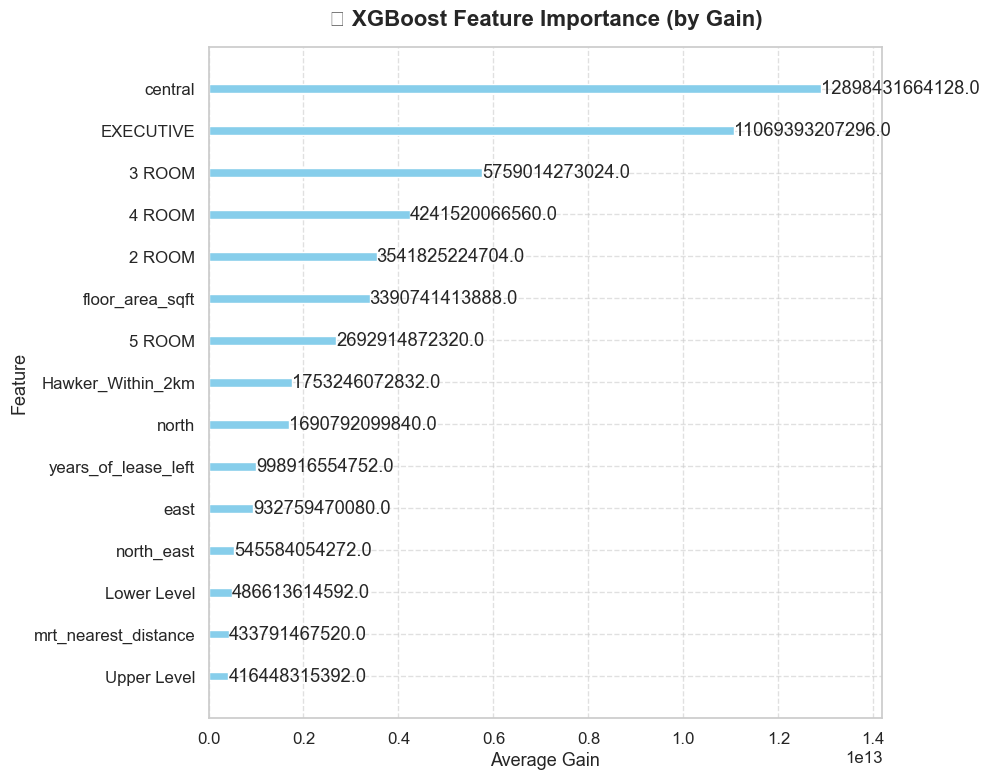

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

fig, ax = plt.subplots(figsize=(10, 8))

plot_importance(
    xgb,
    ax=ax,
    importance_type='gain',
    max_num_features=15,
    color='skyblue'
)

ax.set_title("XGBoost Feature Importance (by Gain)", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Average Gain", fontsize=13)
ax.set_ylabel("Feature", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [82]:
test_data.to_csv('test_final_data.csv')